# Universal Perturbation Attack on Differentiable No-Reference Image- and Video-Quality Metrics

Content: <br />
1. UAP attack
2. UAP preprocessing before compression
3. Stability score



## 0. Download the target metric model

In [ ]:
# download the model
!wget -O RoIPoolModel.pth -N https://github.com/baidut/PaQ-2-PiQ/releases/download/v1.0/RoIPoolModel-fit.10.bs.120.pth

# download a test image
!wget -N https://github.com/baidut/PaQ-2-PiQ/releases/download/v1.0/Picture1.jpg

# download the standalone version of code
!wget -N https://raw.githubusercontent.com/baidut/PaQ-2-PiQ_GAE/master/paq2piq_standalone.py

In [ ]:
from paq2piq_standalone import *

paq2piq = InferenceModel(RoIPoolModel(), 'RoIPoolModel.pth')

## UAP attack

In [3]:
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [4]:
uap = cv2.imread('./uap/pretrained_uap_paq2piq.png')
uap = cv2.cvtColor(uap, cv2.COLOR_BGR2RGB)
uap = uap.astype('float32') / 255.
uap -= 0.5

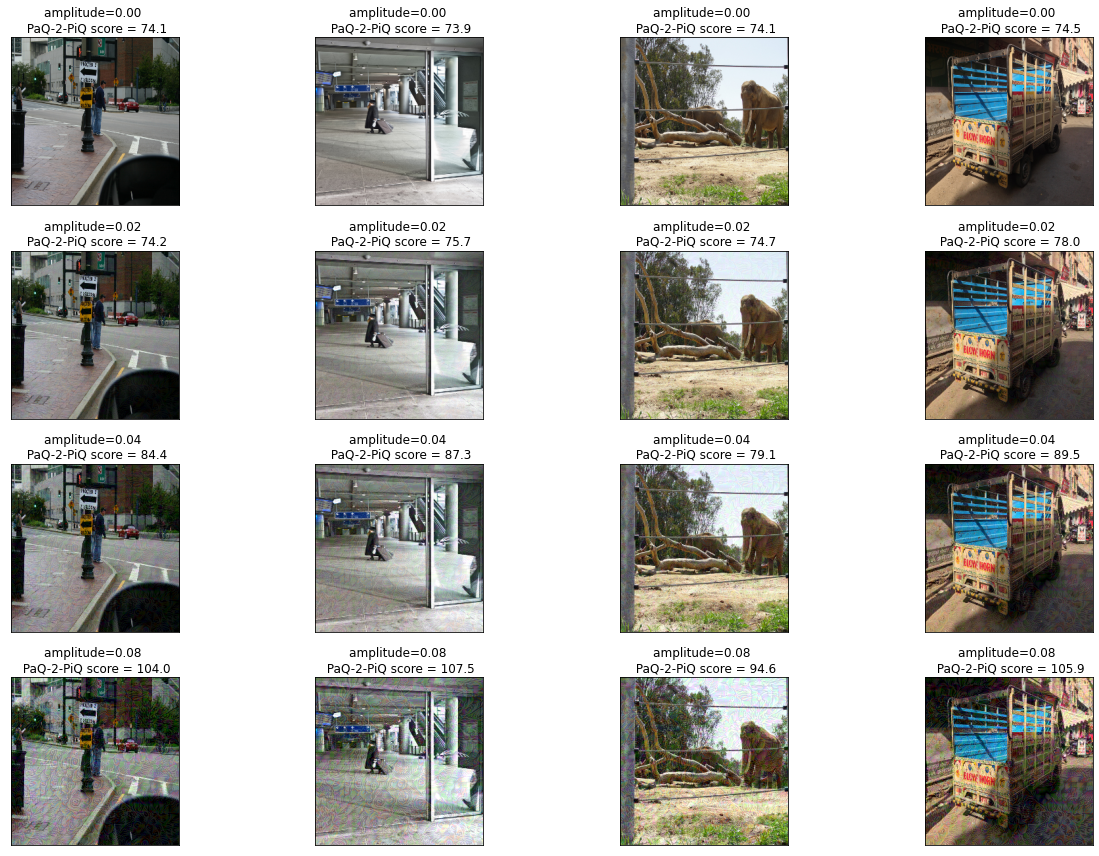

In [157]:
fig, ax = plt.subplots(4, 4, figsize=(18, 12))
for k in range(1, 5):
  im = cv2.imread(f'./test_ims/img_{k}.png')
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  score = paq2piq.predict(im)['global_score']
  im = im.astype('float32') / 255.
  ax[0][k-1].imshow(im)
  ax[0][k-1].get_xaxis().set_ticks([])
  ax[0][k-1].get_yaxis().set_ticks([])
  ax[0][k-1].set_title(f'amplitude=0.00 \n PaQ-2-PiQ score = {score:.1f}')

  # uap pixels are in [-0.1, 0.1] range
  # apply uap with amplitude = 0.02
  amp_02 = im + uap * 0.2
  amp_02[amp_02 > 1] = 1
  amp_02[amp_02 < 0] = 0
  ax[1][k-1].imshow(amp_02)
  ax[1][k-1].get_xaxis().set_ticks([])
  ax[1][k-1].get_yaxis().set_ticks([])
  amp_02 = (amp_02 * 255).astype('uint8')
  score = paq2piq.predict(amp_02)['global_score']
  ax[1][k-1].set_title(f'amplitude=0.02 \n PaQ-2-PiQ score = {score:.1f}')

  # apply uap with amplitude = 0.04
  amp_04 = im + uap * 0.4
  amp_04[amp_04 > 1] = 1
  amp_04[amp_04 < 0] = 0
  ax[2][k-1].imshow(amp_04)
  ax[2][k-1].get_xaxis().set_ticks([])
  ax[2][k-1].get_yaxis().set_ticks([])
  amp_04 = (amp_04 * 255).astype('uint8')
  score = paq2piq.predict(amp_04)['global_score']
  ax[2][k-1].set_title(f'amplitude=0.04 \n PaQ-2-PiQ score = {score:.1f}')

  # apply uap with amplitude = 0.08
  amp_08 = im + uap * 0.8
  amp_08[amp_08 > 1] = 1
  amp_08[amp_08 < 0] = 0
  ax[3][k-1].imshow(amp_08)
  ax[3][k-1].get_xaxis().set_ticks([])
  ax[3][k-1].get_yaxis().set_ticks([])
  amp_08 = (amp_08 * 255).astype('uint8')
  score = paq2piq.predict(amp_08)['global_score']
  ax[3][k-1].set_title(f'amplitude=0.08 \n PaQ-2-PiQ score = {score:.1f}')
plt.tight_layout()

## UAP preprocessing before compression

In [5]:
!pip install sk-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import numpy as np
import skvideo.io
import os
import subprocess 
from skimage.metrics import peak_signal_noise_ratio

In [7]:
# construct high-resolution 1920x1080 perturbation by repeating low-resolution 256x256 perturbation
uap_256x256 = cv2.imread('./uap/pretrained_uap_paq2piq.png')
uap_256x256 = cv2.cvtColor(uap_256x256, cv2.COLOR_BGR2RGB).astype('float32')
uap_256x256 /= 255.
uap_256x256 -= 0.5
uap_1920x1080 = np.tile(uap_256x256,(1080//256 + 1, 1920//256 + 1, 1))[:1080, :1920, :]

In [8]:
videos = ['aspen', 'blue_sky', 'controlled_burn', 'crowd_run', 'dinner', 'ducks', 'in_to_tree', 'life', 'old_town_cross',
'park', 'pedestrian_area', 'red_kayak', 'riverbed', 'rush_field_cuts', 'rush_hour', 'speed_bag', 'station', 'sunflower',
'touchdown_pass', 'tractor']
ampl = [0.02, 0.04, 0.06, 0.08]

In [42]:
# apply uap preprocessing to 20 FullHD videos and compress with 4 bitrates
# save compress only
for video in ['aspen']:
  os.chdir('./videos/')
  bits = ['200k','1M', '5M', '12M']
  for b in bits:
    subprocess.run(['ffmpeg', '-s', '1920x1080', '-pix_fmt', 'yuv420p', '-i',
            video+'.yuv', '-c:v', 'libx264', '-b', b, video+'_'+b+'.mp4'])
  for a in ampl:
    input_file = './videos/'+video+'.yuv'
    output_file = f'./videos/preprocessed_0{int(a*100)}/'+video+'.yuv'
    video_data = skvideo.io.vread(input_file, 1080,1920, inputdict={'-pix_fmt':'yuv420p'})
    video_length = video_data.shape[0]
    video_channel = video_data.shape[3]
    video_height = video_data.shape[1]
    video_width = video_data.shape[2]
    for i in range(video_length):
      frame = video_data[i]
      frame = frame.astype('float32') / 255. + uap_1920x1080 * 10 * a
      frame[frame > 1] = 1
      frame[frame < 0] = 0
      frame = (frame * 255).astype('uint8')
      video_data[i] = frame
    skvideo.io.vwrite(output_file, video_data, outputdict={'-pix_fmt':'yuv420p'})
    os.chdir(f'./videos/preprocessed_0{int(a*100)}')
    bits = ['200k','1M', '5M', '12M']
    for b in bits:
      subprocess.run(['ffmpeg', '-s', '1920x1080', '-pix_fmt', 'yuv420p', '-i',
            video+'.yuv', '-c:v', 'libx264', '-b', b, video+'_'+b+'.mp4'])
    os.remove(output_file)

In [ ]:
# calculate target metric and PSNR scores on compressed videos with and without preprocessing
bits = ['200k','1M', '5M', '12M']
ampl = ['preprocessed_02', 'preprocessed_04', 'preprocessed_06', 'preprocessed_08']
for video in ['aspen']:
  for a in ampl:
    scores = []
    psnrs = []
    orig_scores = []
    for b in bits:
      input_file = './videos/'+a+'/'+video+'_'+b+'.mp4'
      video_data = skvideo.io.vread(input_file)
      video_length = video_data.shape[0]
      orig_input_file = './videos/'+video+'_'+b+'.mp4'
      orig_video_data = skvideo.io.vread(orig_input_file)
      score = []
      orig_score = []
      psnr = []
      print(a, b)
      for i in tqdm(range(video_length)):
        frame = video_data[i]
        orig_frame = orig_video_data[i]
        score.append(paq2piq.predict(frame)['global_score'])
        orig_score.append(paq2piq.predict(orig_frame)['global_score'])
        psnr.append(peak_signal_noise_ratio(frame, orig_frame))
      psnrs.append(np.array(psnr).mean())
      scores.append(np.array(score).mean())
      orig_scores.append(np.array(orig_score).mean())
    np.save('./scores/a'+a[-2:]+'/paq2piq/'+video+'.npy', np.array(scores))
    np.save('./scores/a'+a[-2:]+'/paq2piq/'+video+'_psnr.npy', np.array(psnrs))
    np.save('./scores/a00/paq2piq'+video+'.npy', np.array(orig_scores))

In [87]:
# download target metric and PSNR scores and real bitrates values for compressed videos
videos = ['aspen', 'dinner', 'pedestrian_area', 'park', 'station', 'old_town_cross', 'tractor', 'sunflower', 'riverbed',
'rush_hour', 'controlled_burn', 'ducks', 'crowd_run', 'in_to_tree', 'touchdown_pass', 'speed_bag', 'rush_field_cuts',
'red_kayak', 'life', 'blue_sky']
ampl = ['a02', 'a04', 'a06', 'a08']
paq2piq_with_preprocessing = np.zeros((len(videos), len(ampl), len(bits)))
psnr_with_preprocessing = np.zeros((len(videos), len(ampl), len(bits)))
psnr_no_preprocessing = np.zeros((len(videos), len(ampl), len(bits)))
paq2piq_no_preprocessing = np.zeros((len(videos), len(ampl), len(bits)))
real_bitrate_with_preprocessing = np.zeros((len(videos), len(ampl), len(bits)))
real_bitrate_no_preprocessing = np.zeros((len(videos), len(ampl), len(bits)))
for i, video in enumerate(videos):
  for j, a in enumerate(ampl):
    paq2piq_with_preprocessing[i][j] = np.load('./scores/'+a+'/paq2piq/'+video+'.npy')
    paq2piq_no_preprocessing[i][j] = np.load('./scores/a00/paq2piq/'+video+'.npy')
    psnr_with_preprocessing[i][j] = np.load('./scores/'+a+'/paq2piq/'+video+'_psnr.npy')
    psnr_no_preprocessing[i][j] = np.load('./scores/a00/paq2piq/'+video+'_psnr.npy')
    real_bitrate_with_preprocessing[i][j] = np.load('./bmvc/real_bitrates/'+a+'/paq2piq/'+video+'.npy')
    real_bitrate_no_preprocessing[i][j] = np.load('./bmvc/real_bitrates/a00/paq2piq/'+video+'.npy')

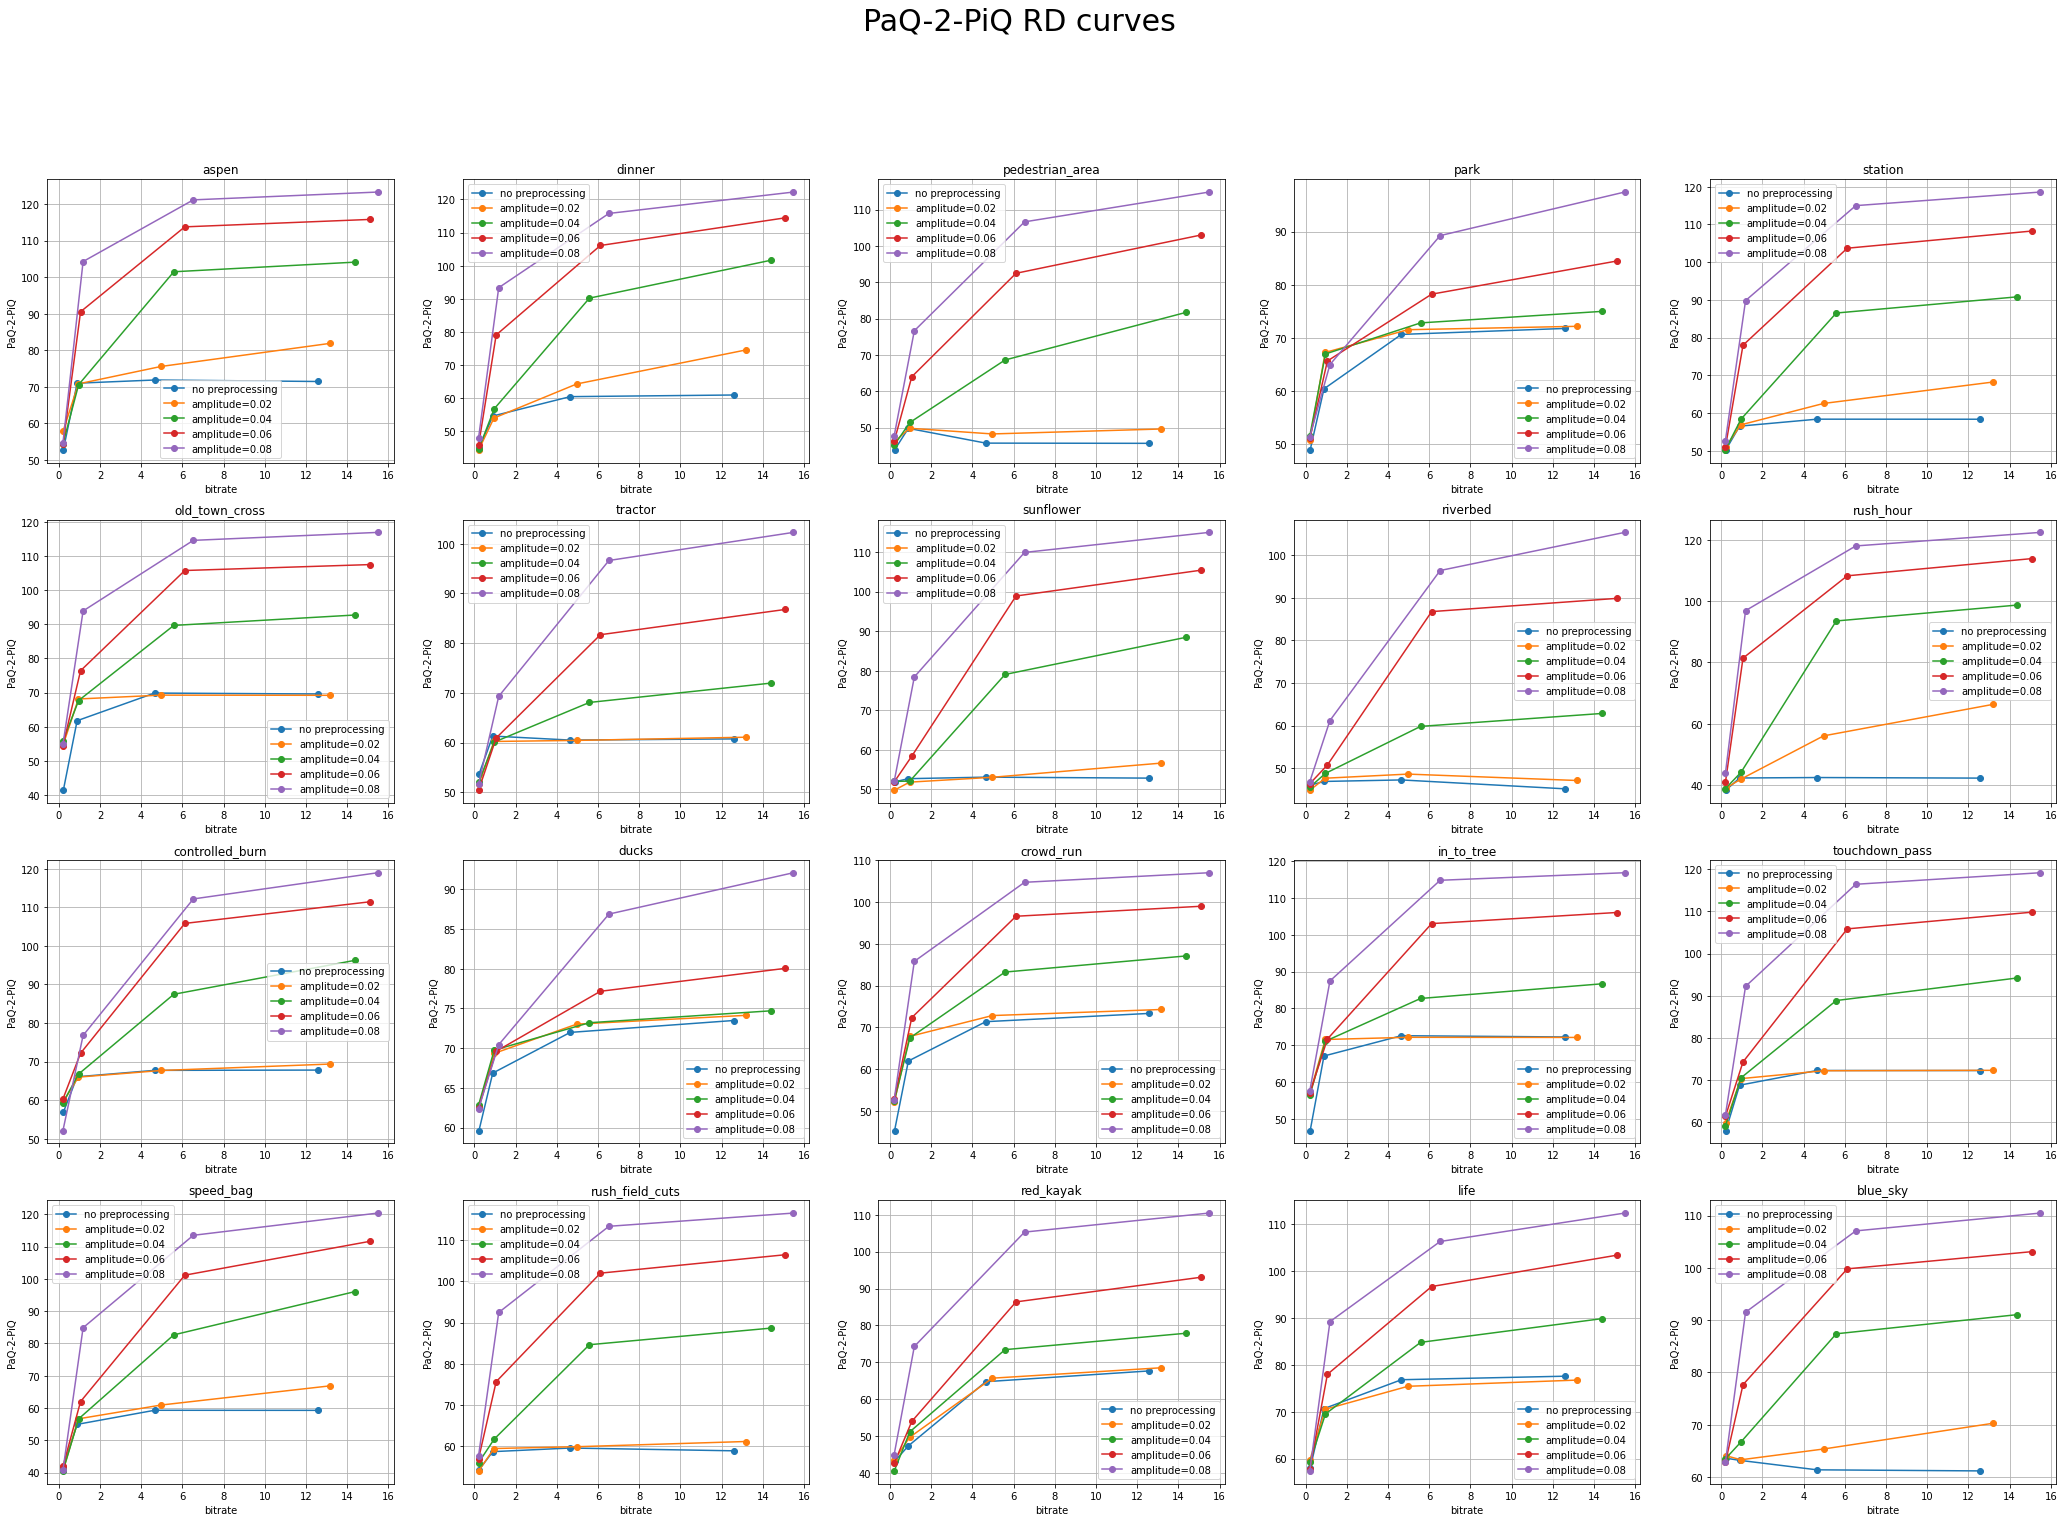

In [85]:
fig, ax = plt.subplots(4, 5, figsize=(36, 24))
bitrate=[]
for k, video in enumerate(videos):
  i = k // 5
  j = k % 5
  ax[i][j].plot(real_bitrate_no_preprocessing[k, 0, :], paq2piq_no_preprocessing[k, 0, :], '-o', label='no preprocessing')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 0, :], paq2piq_with_preprocessing[k, 0, :], '-o', label='amplitude=0.02')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 1, :], paq2piq_with_preprocessing[k, 1, :], '-o', label='amplitude=0.04')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 2, :], paq2piq_with_preprocessing[k, 2, :], '-o', label='amplitude=0.06')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 3, :], paq2piq_with_preprocessing[k, 3, :], '-o', label='amplitude=0.08')
  ax[i][j].grid()
  ax[i][j].legend()
  ax[i][j].set_ylabel('PaQ-2-PiQ')
  ax[i][j].set_xlabel('bitrate')
  ax[i][j].set_title(video)
fig.suptitle('PaQ-2-PiQ RD curves', fontsize=30)
plt.show()

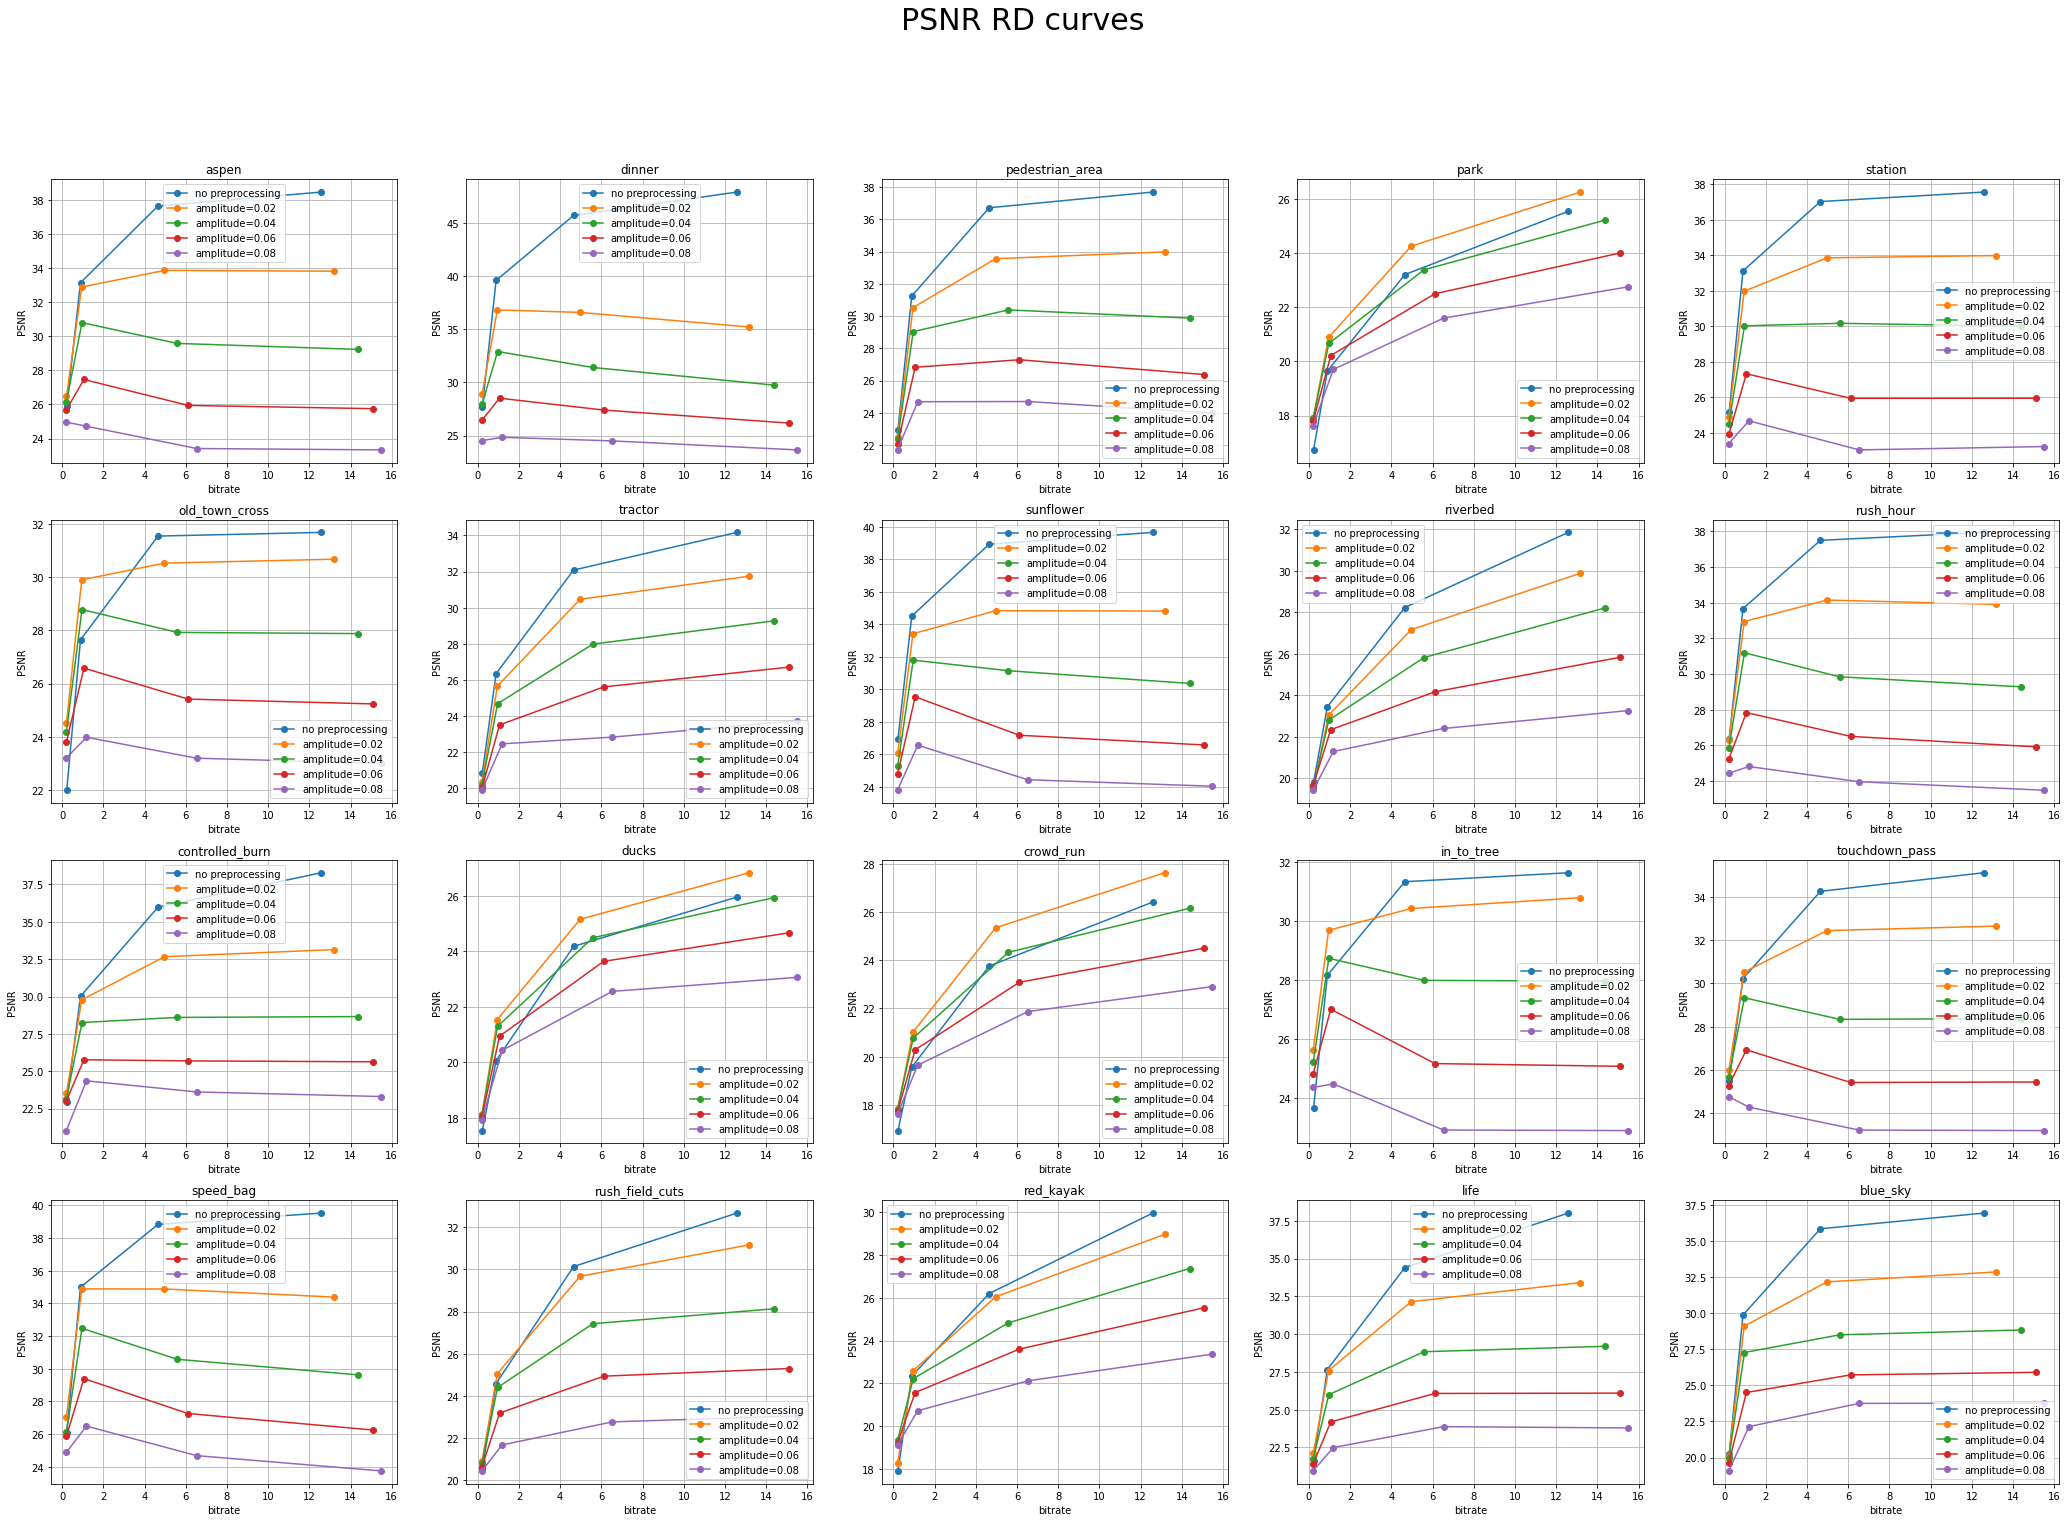

In [88]:
fig, ax = plt.subplots(4, 5, figsize=(36, 24))
bitrate=[]
for k, video in enumerate(videos):
  i = k // 5
  j = k % 5
  ax[i][j].plot(real_bitrate_no_preprocessing[k, 0, :], psnr_no_preprocessing[k, 0, :], '-o', label='no preprocessing')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 0, :], psnr_with_preprocessing[k, 0, :], '-o', label='amplitude=0.02')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 1, :], psnr_with_preprocessing[k, 1, :], '-o', label='amplitude=0.04')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 2, :], psnr_with_preprocessing[k, 2, :], '-o', label='amplitude=0.06')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 3, :], psnr_with_preprocessing[k, 3, :], '-o', label='amplitude=0.08')
  ax[i][j].grid()
  ax[i][j].legend()
  ax[i][j].set_ylabel('PSNR')
  ax[i][j].set_xlabel('bitrate')
  ax[i][j].set_title(video)
fig.suptitle('PSNR RD curves', fontsize=30)
plt.show()

In [90]:
# PaQ-2-PiQ RD curves normalization
m1 = min(paq2piq_with_preprocessing.min(), paq2piq_no_preprocessing.min())
m2 = max(paq2piq_with_preprocessing.max(), paq2piq_no_preprocessing.max())
norm_paq2piq_with_preprocessing = (paq2piq_with_preprocessing - m1) / (m2 - m1)
norm_paq2piq_no_preprocessing = (paq2piq_no_preprocessing - m1) / (m2 - m1)

In [91]:
# PSNR RD curves normalization
m1 = min(psnr_with_preprocessing.min(), psnr_no_preprocessing.min())
m2 = max(psnr_with_preprocessing.max(), psnr_no_preprocessing.max())
norm_psnr_with_preprocessing = (psnr_with_preprocessing - m1) / (m2 - m1)
norm_psnr_no_preprocessing = (psnr_no_preprocessing - m1) / (m2 - m1)

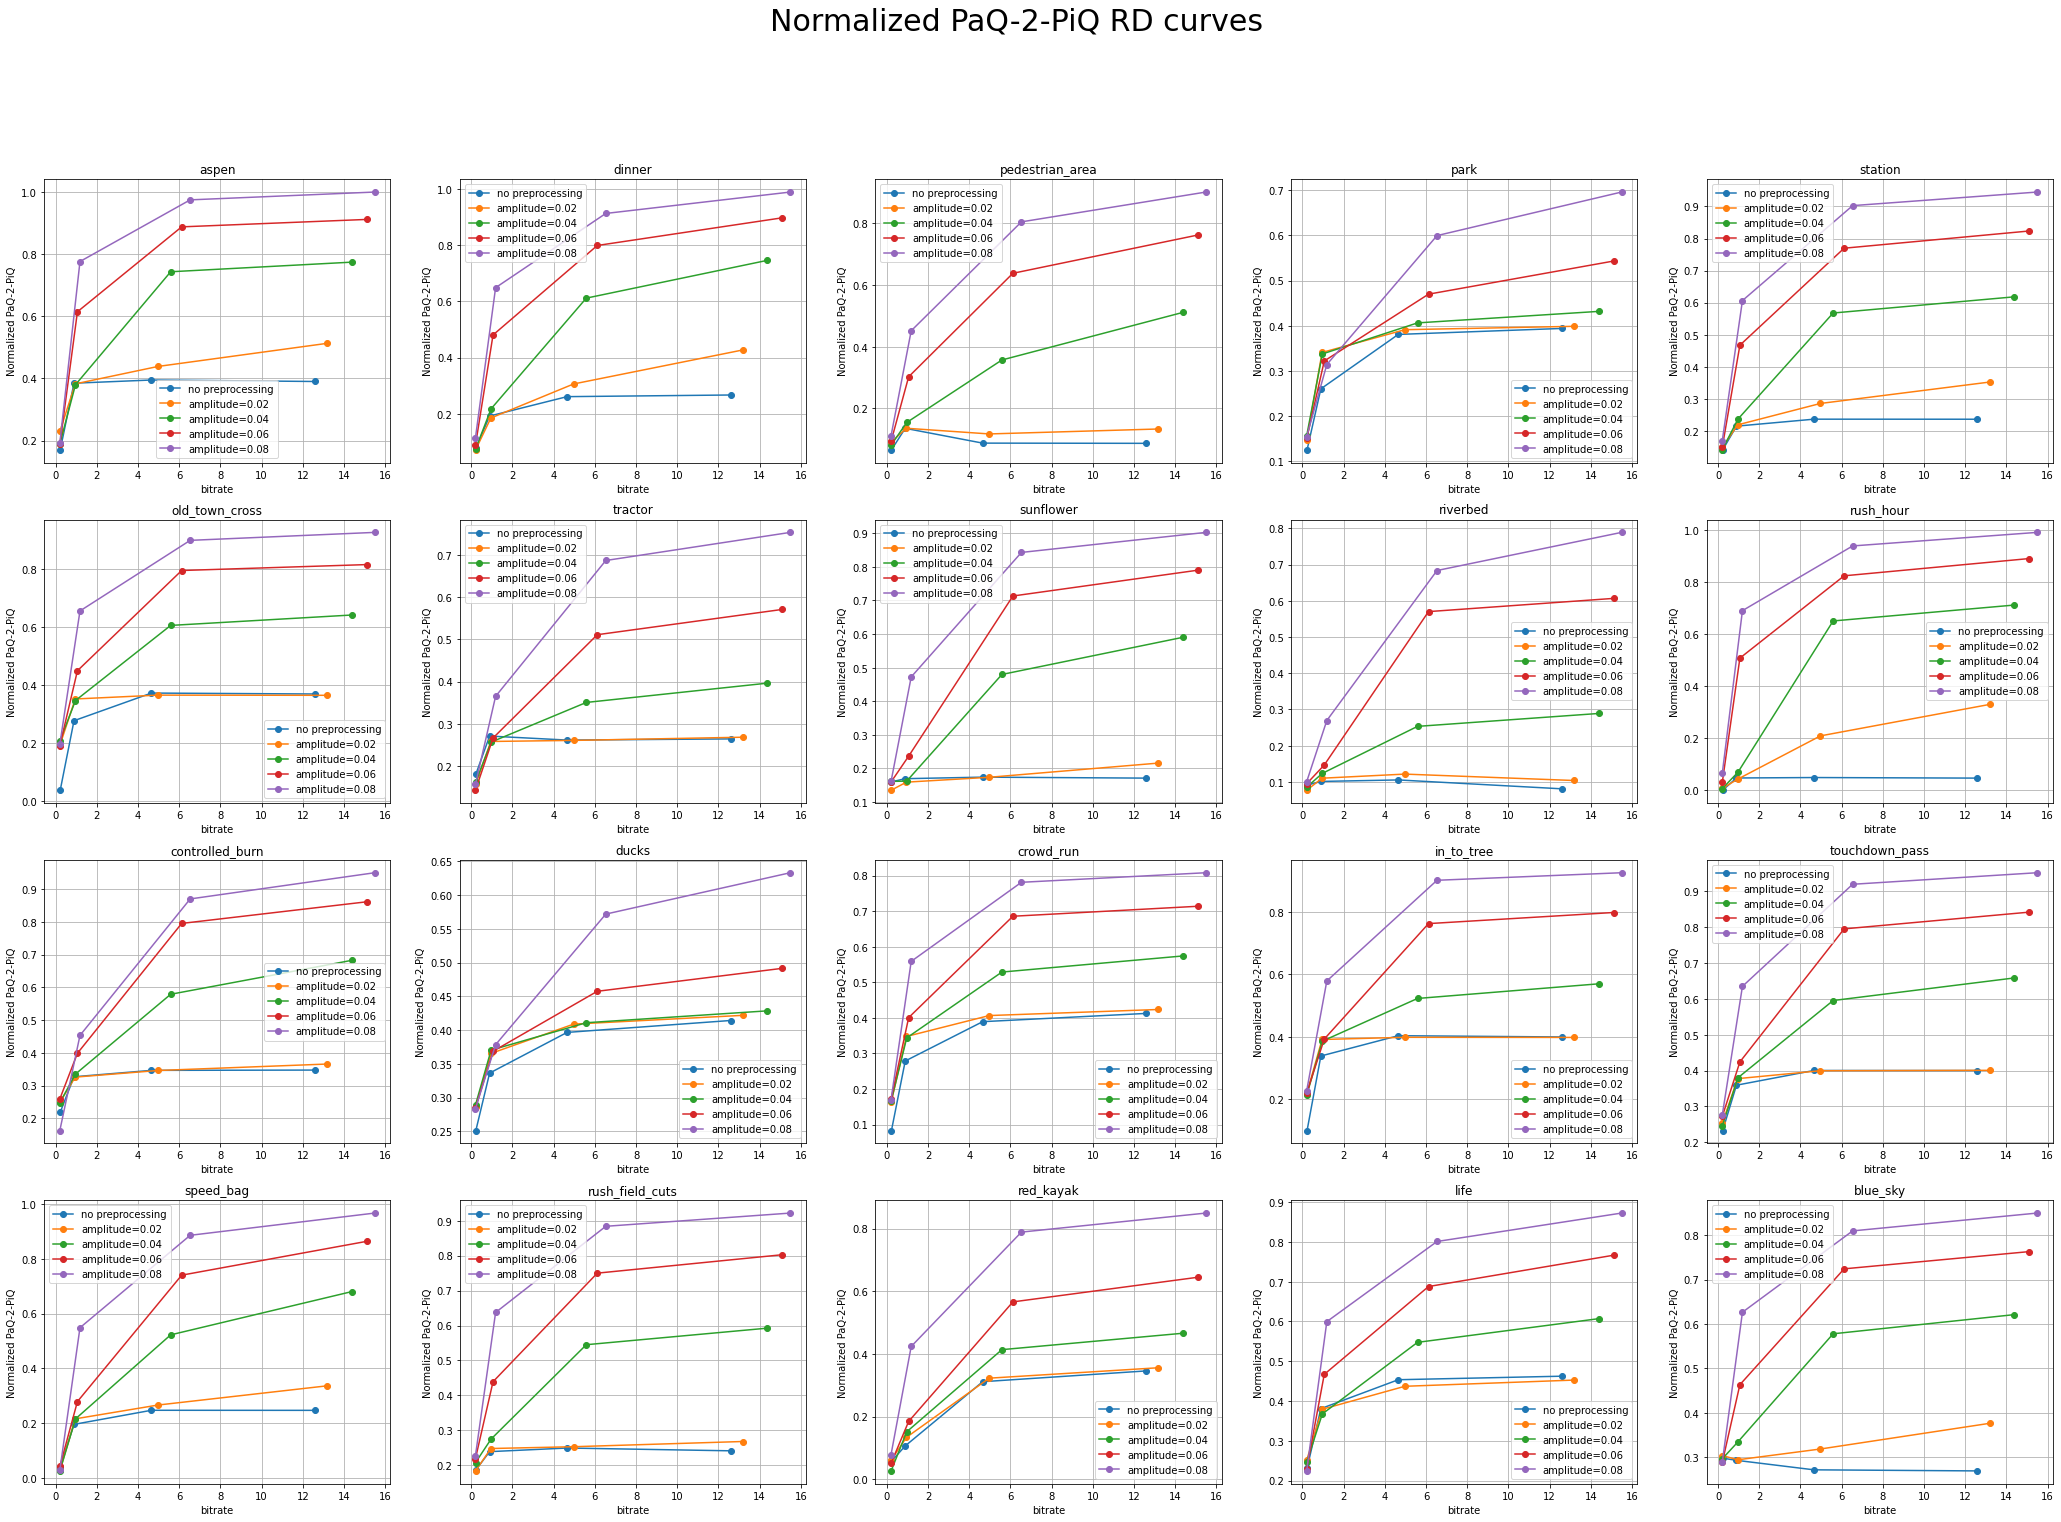

In [92]:
fig, ax = plt.subplots(4, 5, figsize=(36, 24))
bitrate=[]
for k, video in enumerate(videos):
  i = k // 5
  j = k % 5
  ax[i][j].plot(real_bitrate_no_preprocessing[k, 0, :], norm_paq2piq_no_preprocessing[k, 0, :], '-o', label='no preprocessing')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 0, :], norm_paq2piq_with_preprocessing[k, 0, :], '-o', label='amplitude=0.02')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 1, :], norm_paq2piq_with_preprocessing[k, 1, :], '-o', label='amplitude=0.04')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 2, :], norm_paq2piq_with_preprocessing[k, 2, :], '-o', label='amplitude=0.06')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 3, :], norm_paq2piq_with_preprocessing[k, 3, :], '-o', label='amplitude=0.08')
  ax[i][j].grid()
  ax[i][j].legend()
  ax[i][j].set_ylabel('Normalized PaQ-2-PiQ')
  ax[i][j].set_xlabel('bitrate')
  ax[i][j].set_title(video)
fig.suptitle('Normalized PaQ-2-PiQ RD curves', fontsize=30)
plt.show()

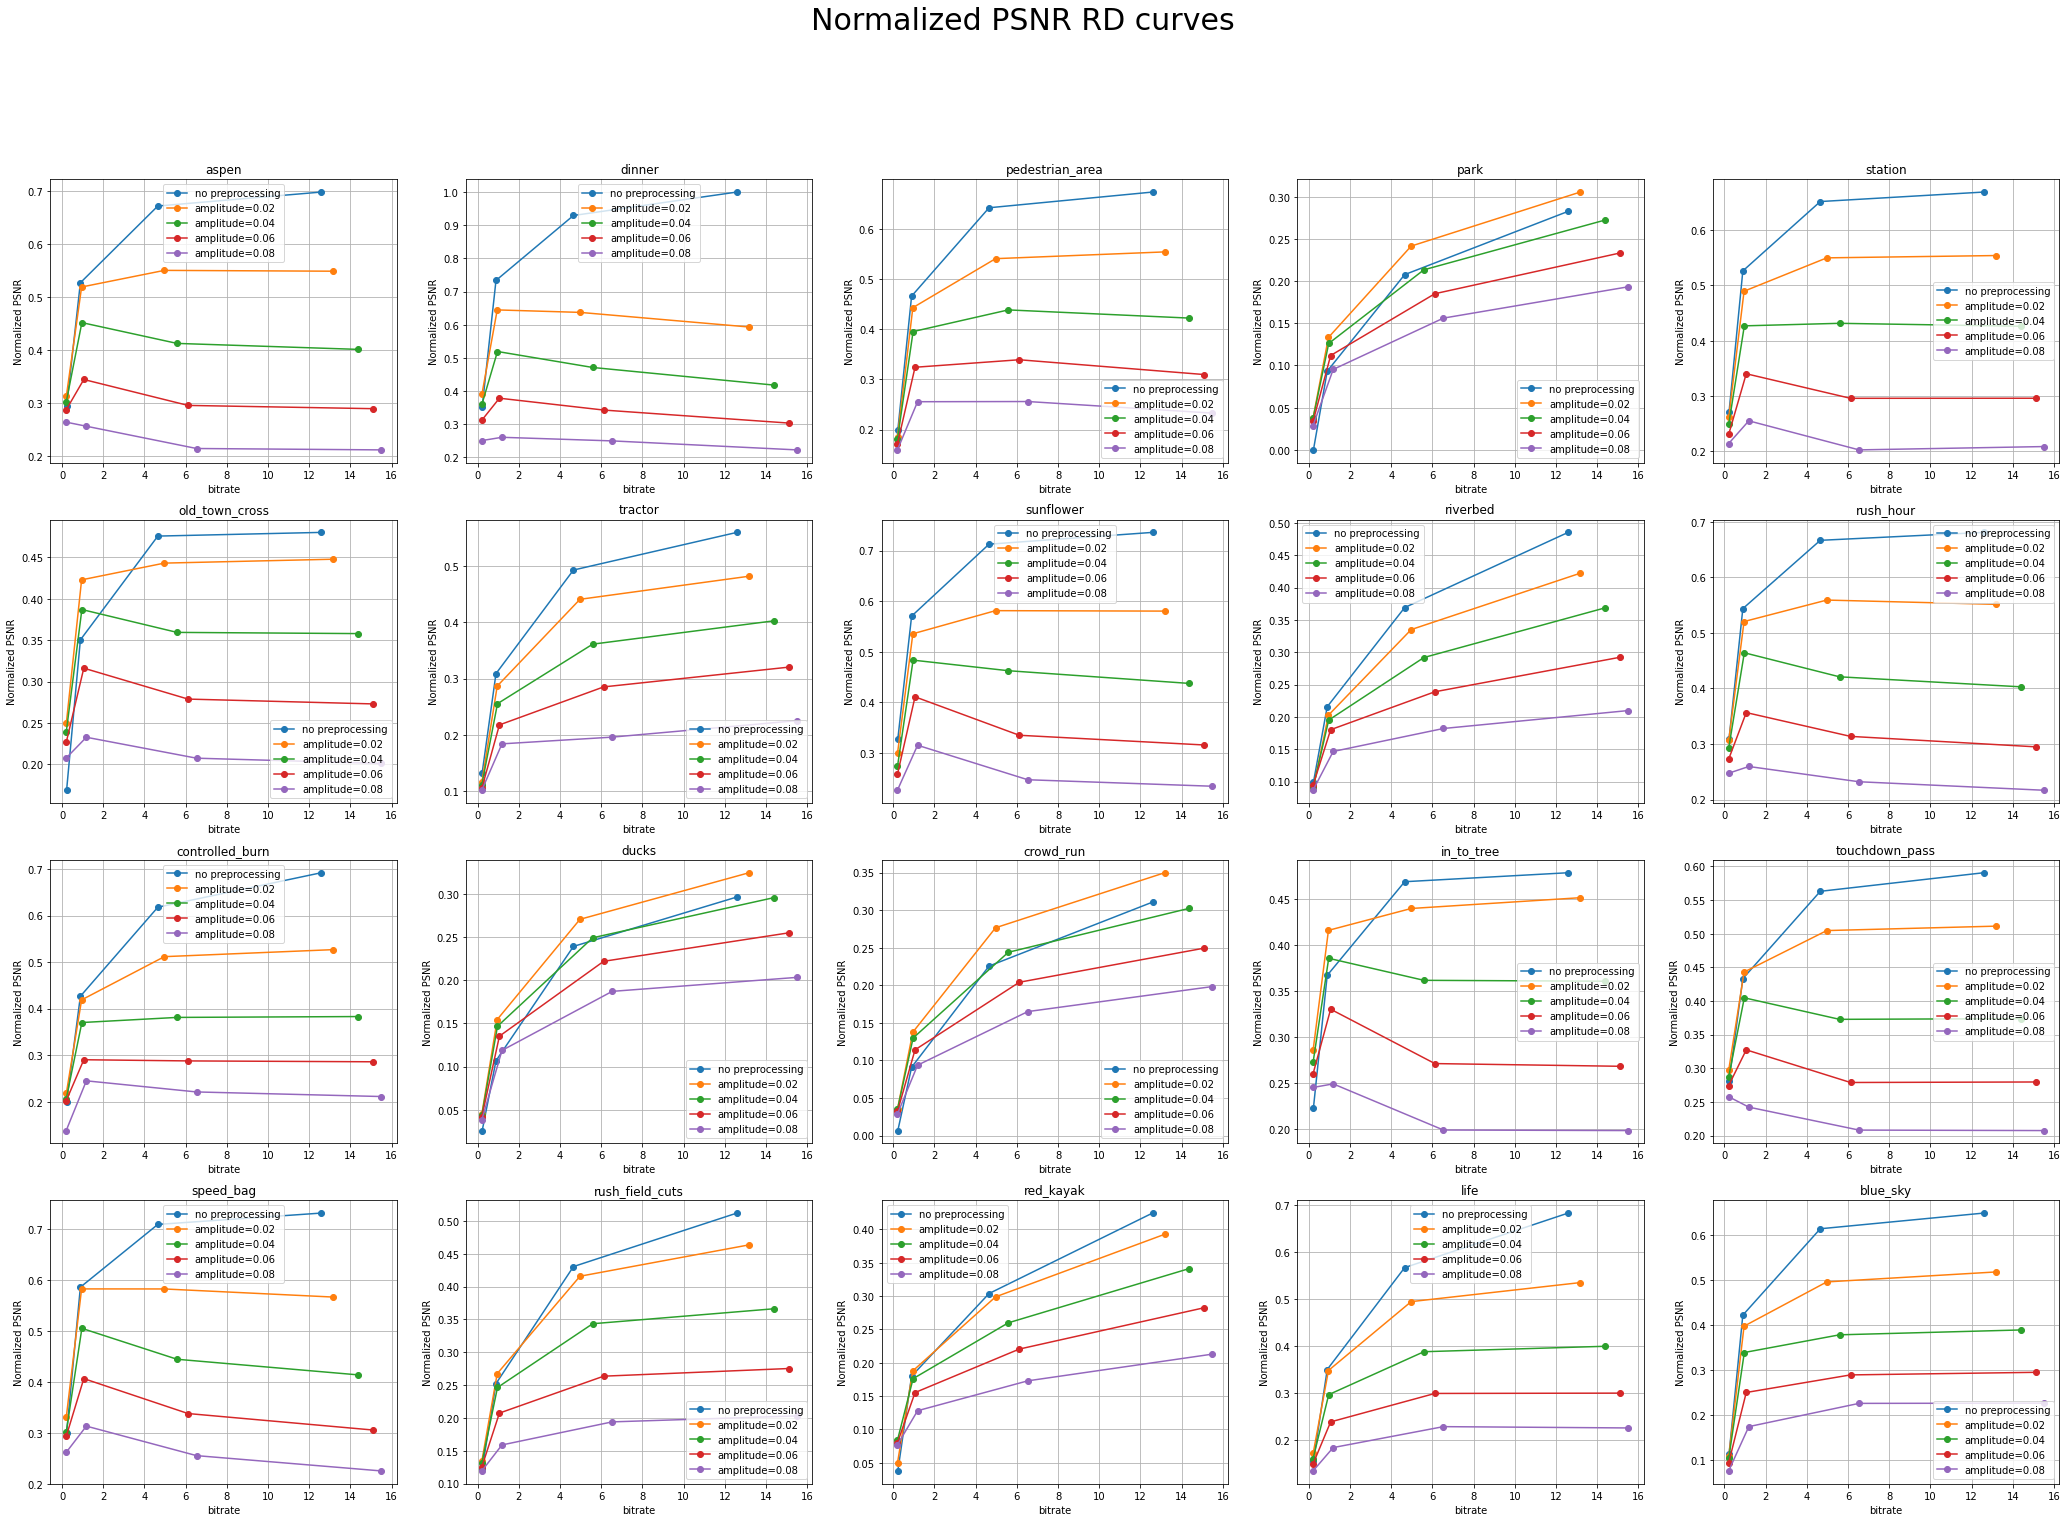

In [93]:
fig, ax = plt.subplots(4, 5, figsize=(36, 24))
bitrate=[]
for k, video in enumerate(videos):
  i = k // 5
  j = k % 5
  ax[i][j].plot(real_bitrate_no_preprocessing[k, 0, :], norm_psnr_no_preprocessing[k, 0, :], '-o', label='no preprocessing')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 0, :], norm_psnr_with_preprocessing[k, 0, :], '-o', label='amplitude=0.02')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 1, :], norm_psnr_with_preprocessing[k, 1, :], '-o', label='amplitude=0.04')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 2, :], norm_psnr_with_preprocessing[k, 2, :], '-o', label='amplitude=0.06')
  ax[i][j].plot(real_bitrate_with_preprocessing[k, 3, :], norm_psnr_with_preprocessing[k, 3, :], '-o', label='amplitude=0.08')
  ax[i][j].grid()
  ax[i][j].legend()
  ax[i][j].set_ylabel('Normalized PSNR')
  ax[i][j].set_xlabel('bitrate')
  ax[i][j].set_title(video)
fig.suptitle('Normalized PSNR RD curves', fontsize=30)
plt.show()

## Stability score

Calculating areas under normalized PaQ-2-PiQ RD curves

In [100]:
areas = []
m = 'paq2piq'
for i in range(20):
  cur = []
  x1 = real_bitrate_no_preprocessing[i, 0, :]
  x2 = real_bitrate_with_preprocessing[i, 0, :]
  m2 = min(x1[-1], x2[-1])
  m1 = max(x1[0], x2[0])

  x1 = (x1 - m1) / (m2 - m1)
  x2 = (x2 - m1) / (m2 - m1)
  if (x1[-1] > 1):
    x1[-1] = 1
  else:
    x2[-1] = 1
  if (x1[0] < 0):
    x1[0] = 0
  else:
    x2[0] = 0

  gain = np.trapz(x=x2, y=norm_paq2piq_with_preprocessing[i][0]) - np.trapz(x=x1, y=norm_paq2piq_no_preprocessing[i][0])
  cur.append(gain)

  x1 = real_bitrate_no_preprocessing[i, 0, :]
  x2 = real_bitrate_with_preprocessing[i, 1, :]
  m2 = min(x1[-1], x2[-1])
  m1 = max(x1[0], x2[0])

  x1 = (x1 - m1) / (m2 - m1)
  x2 = (x2 - m1) / (m2 - m1)
  if (x1[-1] > 1):
    x1[-1] = 1
  else:
    x2[-1] = 1
  if (x1[0] < 0):
    x1[0] = 0
  else:
    x2[0] = 0

  gain = np.trapz(x=x2, y=norm_paq2piq_with_preprocessing[i][1]) - np.trapz(x=x1, y=norm_paq2piq_no_preprocessing[i][0])
  cur.append(gain)


  x1 = real_bitrate_no_preprocessing[i, 0, :]
  x2 = real_bitrate_with_preprocessing[i, 2, :]
  m2 = min(x1[-1], x2[-1])
  m1 = max(x1[0], x2[0])
  x1 = (x1 - m1) / (m2 - m1)
  x2 = (x2 - m1) / (m2 - m1)
  if (x1[-1] > 1):
    x1[-1] = 1
  else:
    x2[-1] = 1
  if (x1[0] < 0):
    x1[0] = 0
  else:
    x2[0] = 0
  gain = np.trapz(x=x2, y=norm_paq2piq_with_preprocessing[i][2]) - np.trapz(x=x1, y=norm_paq2piq_no_preprocessing[i][0])
  cur.append(gain)

  x1 = real_bitrate_no_preprocessing[i, 0, :]
  x2 = real_bitrate_with_preprocessing[i, 3, :]
  m2 = min(x1[-1], x2[-1])
  m1 = max(x1[0], x2[0])
  x1 = (x1 - m1) / (m2 - m1)
  x2 = (x2 - m1) / (m2 - m1)
  if (x1[-1] > 1):
    x1[-1] = 1
  else:
    x2[-1] = 1
  if (x1[0] < 0):
    x1[0] = 0
  else:
    x2[0] = 0
  gain = np.trapz(x=x2, y=norm_paq2piq_with_preprocessing[i][3]) - np.trapz(x=x1, y=norm_paq2piq_no_preprocessing[i][0])
  cur.append(gain)
  areas.append(cur)
np.save('./areas_under_rd_curves/paq2piq/paq2piq.npy', np.array(areas))

Calculating areas under normalized PSNR RD curves

In [101]:
areas = []
m = 'paq2piq'
for i in range(20):
  cur = []
  x1 = real_bitrate_no_preprocessing[i, 0, :]
  x2 = real_bitrate_with_preprocessing[i, 0, :]
  m2 = min(x1[-1], x2[-1])
  m1 = max(x1[0], x2[0])

  dr = norm_psnr_no_preprocessing[0][0].copy()
  if x1[-1] > m2:
    z = x1[-1] - m2
    sb = x1[-1] - x1[-2]
    sa = norm_psnr_with_preprocessing[0][0][-1] - norm_psnr_no_preprocessing[0][0][-2]
    dx = (sb - z) / sb * sa
    dr[-1] = dr[-2] + dx

  x1 = (x1 - m1) / (m2 - m1)
  x2 = (x2 - m1) / (m2 - m1)
  if (x1[-1] > 1):
    x1[-1] = 1
  else:
    x2[-1] = 1
  if (x1[0] < 0):
    x1[0] = 0
  else:
    x2[0] = 0

  gain = np.trapz(x=x2, y=norm_psnr_with_preprocessing[0][0]) - np.trapz(x=x1, y=dr)
  gain *= -1
  cur.append(gain)

  x1 = real_bitrate_no_preprocessing[i, 0, :]
  x2 = real_bitrate_with_preprocessing[i, 1, :]
  m2 = min(x1[-1], x2[-1])
  m1 = max(x1[0], x2[0])

  dr = norm_psnr_no_preprocessing[0][0].copy()
  if x1[-1] > m2:
    z = x1[-1] - m2
    sb = x1[-1] - x1[-2]
    sa = norm_psnr_no_preprocessing[0][0][-1] - norm_psnr_no_preprocessing[0][0][-2]
    dx = (sb - z) / sb * sa
    dr[-1] = dr[-2] + dx

  x1 = (x1 - m1) / (m2 - m1)  
  x2 = (x2 - m1) / (m2 - m1)
  if (x1[-1] > 1):
    x1[-1] = 1
  else:
    x2[-1] = 1
  if (x1[0] < 0):
    x1[0] = 0
  else:
    x2[0] = 0

  gain = np.trapz(x=x2, y=norm_psnr_with_preprocessing[0][1]) - np.trapz(x=x1, y=dr)
  gain *= -1
  cur.append(gain)
  x1 = real_bitrate_no_preprocessing[i, 0, :]
  x2 = real_bitrate_with_preprocessing[i, 2, :]
  m2 = min(x1[-1], x2[-1])
  m1 = max(x1[0], x2[0])
  dr = norm_psnr_no_preprocessing[0][0].copy()
  if x1[-1] > m2:
    z = x1[-1] - m2
    sb = x1[-1] - x1[-2]
    sa = norm_psnr_no_preprocessing[0][0][-1] - norm_psnr_no_preprocessing[0][0][-2]
    dx = (sb - z) / sb * sa
    dr[-1] = dr[-2] + dx

  x1 = (x1 - m1) / (m2 - m1)
  x2 = (x2 - m1) / (m2 - m1)
  if (x1[-1] > 1):
    x1[-1] = 1
  else:
    x2[-1] = 1
  if (x1[0] < 0):
    x1[0] = 0
  else:
    x2[0] = 0
  gain = np.trapz(x=x2, y=norm_psnr_with_preprocessing[0][2]) - np.trapz(x=x1, y=dr)
  gain *= -1
  cur.append(gain)
  areas.append(cur)
np.save('./areas_under_rd_curves/paq2piq/psnr.npy', np.array(areas))

Plot target-metric gain vs proxy-loss dependencies for all tested metrics (areas under all metrics calculated as in example for PaQ-2-PiQ target metric)

In [110]:
metrics = ['paq2piq', 'linearity', 'vsfa', 'mdtvsfa', 'koncept', 'spaq', 'nima']

In [111]:
psnr_loss = np.zeros((7, 20, 4))
gains = np.zeros((7, 20, 4))

In [112]:
for i in range(7):
  psnr_loss[i] = np.load('./areas_under_rd_curves/'+metrics[i]+'/psnr.npy')
  gains[i] = np.load('./areas_under_rd_curves/'+metrics[i]+'/'+metrics[i]+'.npy')

In [113]:
psnr_loss = psnr_loss.mean(axis=1)
gains = gains.mean(axis=1)

In [118]:
print(psnr_loss[:,0].max())
print(psnr_loss[:,3].min())

0.10414153044896239
0.361463536197134


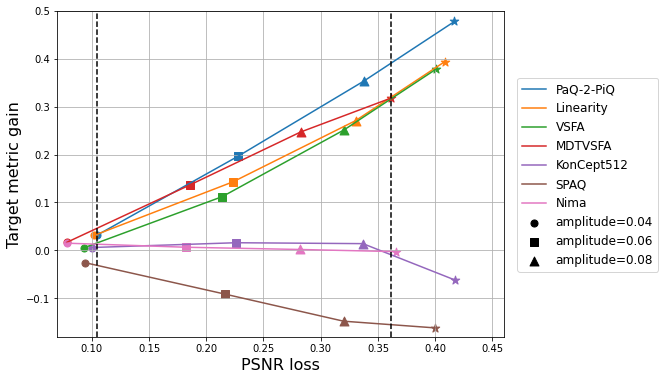

In [129]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(psnr_loss[0], gains[0], label='PaQ-2-PiQ', color='tab:blue')
plt.plot(psnr_loss[1], gains[1], label='Linearity', color='tab:orange')
plt.plot(psnr_loss[2], gains[2], label='VSFA', color='tab:green')
plt.plot(psnr_loss[3], gains[3], label='MDTVSFA', color='tab:red')
plt.plot(psnr_loss[4], gains[4], label='KonCept512', color='tab:purple')
plt.plot(psnr_loss[5], gains[5], label='SPAQ', color='tab:brown')
plt.plot(psnr_loss[6], gains[6], label='Nima', color='tab:pink')
plt.scatter([psnr_loss[0][0]], [gains[0][0]], marker='o', s=[50], color='tab:blue')
plt.scatter([psnr_loss[0][1]], [gains[0][1]], marker='s', s=[50], color='tab:blue')
plt.scatter([psnr_loss[0][2]], [gains[0][2]], marker='^', s=[80], color='tab:blue')
plt.scatter([psnr_loss[0][3]], [gains[0][3]], marker='*', s=[80], color='tab:blue')

plt.scatter([psnr_loss[1][0]], [gains[1][0]], marker='o', s=[50], color='tab:orange')
plt.scatter([psnr_loss[1][1]], [gains[1][1]], marker='s', s=[50], color='tab:orange')
plt.scatter([psnr_loss[1][2]], [gains[1][2]], marker='^', s=[80], color='tab:orange')
plt.scatter([psnr_loss[1][3]], [gains[1][3]], marker='*', s=[80], color='tab:orange')

plt.scatter([psnr_loss[2][0]], [gains[2][0]], marker='o', s=[50], color='tab:green')
plt.scatter([psnr_loss[2][1]], [gains[2][1]], marker='s', s=[50], color='tab:green')
plt.scatter([psnr_loss[2][2]], [gains[2][2]], marker='^', s=[80], color='tab:green')
plt.scatter([psnr_loss[2][3]], [gains[2][3]], marker='*', s=[80], color='tab:green')

plt.scatter([psnr_loss[3][0]], [gains[3][0]], marker='o', s=[50], color='tab:red')
plt.scatter([psnr_loss[3][1]], [gains[3][1]], marker='s', s=[50], color='tab:red')
plt.scatter([psnr_loss[3][2]], [gains[3][2]], marker='^', s=[80], color='tab:red')
plt.scatter([psnr_loss[3][3]], [gains[3][3]], marker='*', s=[80], color='tab:red')

plt.scatter([psnr_loss[4][0]], [gains[4][0]], marker='o', s=[50], color='tab:purple')
plt.scatter([psnr_loss[4][1]], [gains[4][1]], marker='s', s=[50], color='tab:purple')
plt.scatter([psnr_loss[4][2]], [gains[4][2]], marker='^', s=[80], color='tab:purple')
plt.scatter([psnr_loss[4][3]], [gains[4][3]], marker='*', s=[80], color='tab:purple')

plt.scatter([psnr_loss[5][0]], [gains[5][0]], marker='o', s=[50], color='tab:brown')
plt.scatter([psnr_loss[5][1]], [gains[5][1]], marker='s', s=[50], color='tab:brown')
plt.scatter([psnr_loss[5][2]], [gains[5][2]], marker='^', s=[80], color='tab:brown')
plt.scatter([psnr_loss[5][3]], [gains[5][3]], marker='*', s=[80], color='tab:brown')

plt.scatter([psnr_loss[6][0]], [gains[6][0]], marker='o', s=[50], color='tab:pink')
plt.scatter([psnr_loss[6][1]], [gains[6][1]], marker='s', s=[50], color='tab:pink')
plt.scatter([psnr_loss[6][2]], [gains[6][2]], marker='^', s=[80], color='tab:pink')
plt.scatter([psnr_loss[6][3]], [gains[6][3]], marker='*', s=[80], color='tab:pink')

plt.axvline(x=0.10414153044896239, linestyle='--', color='k')
plt.axvline(x=0.361463536197134, linestyle='--', color='k')
plt.scatter([-10], [-20], marker='o', s=[50], color='k', label='amplitude=0.04')
plt.scatter([-20], [-10], marker='s', s=[50], color='k', label='amplitude=0.06')
plt.scatter([-10], [-10], marker='^', s=[80], color='k', label='amplitude=0.08')
plt.grid()
plt.legend(fontsize=12, loc=(1.03, 0.2))
plt.xlabel('PSNR loss', fontsize=16)
plt.ylabel('Target metric gain', fontsize=16)
ax.set_xlim(0.07, 0.46)
ax.set_ylim(-0.18, 0.5)

plt.show()

Stability score calculation based on these dependencies: areas under plots multiplyed by 100 with opposite sign

In [130]:
# find upper bound
g = []
for i in range(7):
  a = gains[i][-1] - gains[i][-2]
  b = psnr_loss[i][-1] - psnr_loss[i][-2]
  d = psnr_loss[i][-1] - 0.361463536197134
  x = a * (b - d) / b
  g.append(gains[i][-2] + x)

In [131]:
# find lowe bound
g2 = []
for i in range(7):
  a = gains[i][1] - gains[i][0]
  b = psnr_loss[i][1] - psnr_loss[i][0]
  d = psnr_loss[i][1] - 0.10414153044896239
  x = a * (b - d) / b
  g2.append(gains[i][0] + x)

In [136]:
for i in range(7):
  x = np.concatenate(([0.10414153044896239], [psnr_loss[i][1]], [psnr_loss[i][2]], [0.361463536197134]))
  y = np.concatenate(([g2[i]], [gains[i][1]], [gains[i][2]], [g[i]]))
  print(metrics[i], 'stability score = ', np.trapz(x=x, y=y)*100*-1)

paq2piq stability score =  -5.312008140643151
linearity stability score =  -4.181954310630905
vsfa stability score =  -3.7997658477012197
mdtvsfa stability score =  -4.829903618533317
koncept stability score =  -0.3123542112925765
spaq stability score =  2.5457691811588075
nima stability score =  -0.1201532196895475
